In [199]:
import numpy as np
import h5py
import torch
import torch.optim as optim
from tqdm import tqdm
import copy
import pandas as pd
import sys
import random
import os
from torch.utils.data import Dataset, DataLoader
from argparse import Namespace
import matplotlib.pyplot as plt


sys.path.append('../')
from utils.misc import args_parser, average_weights
from utils.misc import get_data, process_isolated
from utils.models import LSTM
from utils.fed_update import LocalUpdate, test_inference
from sklearn import metrics

In [200]:
args = Namespace(
    close_size = 3,
    period_size = 3,
    out_dim = 1,
    test_days = 7,
    val_days = 0,
    seed = 1,
    bs = 100,
    frac = 0.1,
    fedsgd = 0,
    local_bs = 20,
    epochs = 100,
    local_epoch = 1,
    input_dim = 1,
    hidden_dim = 64,
    num_layers = 2,
    gpu = 'cuda',
    lr = 1e-2,
    opt = 'sgd',
    momentum = 0.9,
    file = 'milano.h5',
    type = 'call',
    batch_szie = 64
    
)


In [201]:
from torch import nn
from torch.autograd import Variable

class WeightLayer(nn.Module):
    def __init__(self):
        super(WeightLayer, self).__init__()
        self.w = nn.Parameter(torch.rand(1, requires_grad=True))

    def forward(self, x):
        return x * self.w


class LSTM(nn.Module):
    def __init__(self, args):
        super(LSTM, self).__init__()
        self.input_dim = args.input_dim
        self.hidden_dim = args.hidden_dim
        self.out_dim = args.out_dim
        self.num_layers = args.num_layers
        self.close_size = args.close_size
        self.period_size = args.period_size
        self.device = 'cuda' if args.gpu else 'cpu'

        self.lstm_close = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers,
                                  batch_first=True, dropout=0.2)
        self.lstm_period = nn.LSTM(input_size=self.input_dim, hidden_size=self.hidden_dim, num_layers=self.num_layers,
                                   batch_first=True, dropout=0.2)

        self.weight_close = WeightLayer()
        self.weight_period = WeightLayer()

        self.linear_layer = nn.Linear(self.hidden_dim, self.out_dim)

    def forward(self, xc, xp=None):
        bz = xc.size(0)
        h0 = Variable(torch.zeros(self.num_layers * 1, bz, self.hidden_dim)).to(self.device)
        c0 = Variable(torch.zeros(self.num_layers * 1, bz, self.hidden_dim)).to(self.device)

        self.lstm_close.flatten_parameters()
        self.lstm_period.flatten_parameters()

        xc_out, xc_hn = self.lstm_close(xc, (h0, c0))
        x = xc_out[:, -1, :]
        if self.period_size > 0:
            xp_out, xp_hn = self.lstm_period(xp, (h0, c0))
            y = xp_out[:, -1, :]
        out = x + y
        y_pred = self.linear_layer(out)
        # y_pred = torch.sigmoid(y_pred)
        return y_pred


In [202]:
def process_isolated(args, dataset):
    train, val, test = dict(), dict(), dict()
    column_names = dataset.columns

    for col in column_names:
        close_arr, period_arr, label_arr = [], [], []

        cell_traffic = dataset[col]
        start_idx = max(args.close_size, args.period_size * 24)
        for idx in range(start_idx, len(dataset) - args.out_dim + 1):
            y_ = [cell_traffic.iloc[idx + i] for i in range(args.out_dim)]
            # y_ = [cell_traffic.iloc[idx + args.out_dim - 1]]
            label_arr.append(y_)

            if args.close_size > 0:
                x_close = [cell_traffic.iloc[idx - c] for c in range(1, args.close_size + 1)]
                close_arr.append(x_close)
            if args.period_size > 0:
                x_period = [cell_traffic.iloc[idx - p * 24] for p in range(1, args.period_size + 1)]
                period_arr.append(x_period)

        cell_arr_close = np.array(close_arr)
        cell_arr_close = cell_arr_close[:, :, np.newaxis]
        cell_label = np.array(label_arr)

        test_len = args.test_days * 24
        val_len = args.val_days * 24
        train_len = len(cell_arr_close) - test_len - val_len

        train_x_close = cell_arr_close[:train_len]
        val_x_close = cell_arr_close[train_len:train_len + val_len]
        test_x_close = cell_arr_close[-test_len:]

        # train_x_close = cell_arr_close[:-test_len][:-val_len]
        # val_x_close = cell_arr_close[:-test_len][-val_len:]
        # test_x_close = cell_arr_close[-test_len:]

        # train_label = cell_label[:-test_len][:-val_len]
        # val_label = cell_label[:-test_len][-val_len:]
        # test_label = cell_label[-test_len:]

        train_label = cell_label[:train_len]
        val_label = cell_label[train_len:train_len + val_len]
        test_label = cell_label[-test_len:]

        if args.period_size > 0:
            cell_arr_period = np.array(period_arr)
            cell_arr_period = cell_arr_period[:, :, np.newaxis]

            # train_x_period = cell_arr_period[:-test_len][:-val_len]
            # val_x_period = cell_arr_period[:-test_len][-val_len:]
            # test_x_period = cell_arr_period[-test_len:]

            train_x_period = cell_arr_period[:train_len]
            val_x_period = cell_arr_period[train_len:train_len + val_len]
            test_x_period = cell_arr_period[-test_len:]

        else:
            train_x_period = train_x_close
            val_x_period = val_x_close
            test_x_period = test_x_close

        train[col] = (train_x_close, train_x_period, train_label)
        val[col] = (val_x_close, val_x_period, val_label)
        test[col] = (test_x_close, test_x_period, test_label)

    return train, val, test

In [204]:
def get_data(args):
    path = os.getcwd()
    f = h5py.File(path + '/dataset/' + args, 'r')

    idx = f['idx'][()]
    cell = f['cell'][()]
    lng = f['lng'][()]
    lat = f['lat'][()]
    data = f['call'][()][:, cell - 1]

    df = pd.DataFrame(data, index=pd.to_datetime(idx.ravel(), unit='s'), columns=cell)
    df.fillna(0, inplace=True)
    print(df)

    random.seed(1)
    cell_pool = cell
    selected_cells = sorted(random.sample(list(cell_pool), bs))
    selected_cells_idx = np.where(np.isin(list(cell), selected_cells))
    cell_lng = lng[selected_cells_idx]
    cell_lat = lat[selected_cells_idx]
    print('Selected cells:', selected_cells)

    df_cells = df[selected_cells]
    # print(df_cells.head())

    train_data = df_cells.iloc[:-test_days * 24]

    mean = train_data.mean()
    std = train_data.std()

    normalized_df = (df_cells - mean) / std

    return normalized_df, df_cells, selected_cells, mean, std, cell_lng, cell_lat

def test_inference(args, model, dataset):
    model.eval()
    loss, mse = 0.0, 0.0
    device = 'cuda' if args.gpu else 'cpu'
    criterion = nn.MSELoss().to(device)
    data_loader = DataLoader(list(zip(*dataset)), batch_size=args.local_bs, shuffle=False)
    pred_list, truth_list = [], []

    with torch.no_grad():
        for batch_idx, (xc, xp, y) in enumerate(data_loader):
            xc, xp = xc.float().to(device), xp.float().to(device)
            y = y.float().to(device)
            pred = model(xc, xp)

            batch_loss = criterion(y, pred)
            loss += batch_loss.item()

            batch_mse = torch.mean((pred - y) ** 2)
            mse += batch_mse.item()

            pred_list.append(pred.detach().cpu())
            truth_list.append(y.detach().cpu())

    final_prediction = np.concatenate(pred_list).ravel()
    final_truth = np.concatenate(truth_list).ravel()
    nrmse= (metrics.mean_squared_error(final_truth, final_prediction) ** 0.5) / (max(final_truth) - min(final_truth))
    avg_loss = loss / len(data_loader)
    avg_mse = mse / len(data_loader)

    return avg_loss, avg_mse, nrmse, final_prediction, final_truth

In [205]:
df,ori_df,selected_cells,_,_,_,_ = get_data("milano.h5")
df

                     1      2      3      4      5      6      7      8      \
2013-11-04 00:00:00  0.271  0.275  0.280  0.258  0.240  0.280  0.280  0.280   
2013-11-04 01:00:00  0.029  0.028  0.027  0.032  0.035  0.027  0.027  0.027   
2013-11-04 02:00:00  0.002  0.001  0.000  0.004  0.005  0.000  0.000  0.000   
2013-11-04 03:00:00  0.002  0.001  0.000  0.004  0.005  0.000  0.000  0.000   
2013-11-04 04:00:00  0.084  0.083  0.082  0.086  0.076  0.082  0.082  0.082   
...                    ...    ...    ...    ...    ...    ...    ...    ...   
2013-12-29 19:00:00  6.700  6.822  6.952  6.348  5.892  6.952  6.952  6.952   
2013-12-29 20:00:00  5.301  5.358  5.418  5.136  4.767  5.418  5.418  5.418   
2013-12-29 21:00:00  4.537  4.583  4.632  4.404  4.068  4.632  4.632  4.632   
2013-12-29 22:00:00  1.554  1.572  1.591  1.503  1.389  1.591  1.591  1.591   
2013-12-29 23:00:00  0.770  0.776  0.783  0.750  0.703  0.783  0.783  0.783   

                     9      10     ...   9991    99

,35,157,214,370,383,436,484,495,504,521,...,9106,9164,9373,9514,9520,9674,9698,9733,9766,10000
2013-11-04 00:00:00,-1.016138,-1.080711,-1.128282,-1.032332,-1.072715,-1.038573,-0.961908,-0.947984,-1.155242,-1.048004,...,-1.117693,-1.079055,-0.961538,-1.091830,-1.129159,-1.028187,-1.076144,-1.072936,-1.168719,-1.102837
2013-11-04 01:00:00,-1.056361,-1.097194,-1.170419,-1.072980,-1.169130,-1.178278,-0.749854,-1.022337,-1.179203,-1.110181,...,-1.165718,-1.184915,-1.043503,-1.130916,-1.180338,-1.046961,-1.113736,-1.072936,-1.180442,-1.110600
2013-11-04 02:00:00,-1.078646,-1.174662,-1.167891,-1.048244,-1.185200,-1.183141,-1.011864,-1.046463,-1.174158,-1.124765,...,-1.171620,-1.218862,-1.082526,-1.160612,-1.213418,-1.048888,-1.117042,-1.087131,-1.207514,-1.166494
2013-11-04 03:00:00,-1.115063,-1.159121,-1.183060,-1.062618,-1.162313,-1.141583,-0.998355,-1.012687,-1.184247,-1.093293,...,-1.171620,-1.195955,-1.083368,-1.163429,-1.210453,-1.056431,-1.092784,-1.072936,-1.220727,-1.166106
2013-11-04 04:00:00,-1.078646,-1.194912,-1.177161,-1.092569,-1.153548,-1.163246,-0.999630,-1.022337,-1.179203,-1.112100,...,-1.166254,-1.191854,-1.076347,-1.156856,-1.206708,-1.048019,-1.117042,-1.087131,-1.205442,-1.149959
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-29 19:00:00,-0.239959,-0.424235,-0.081595,0.167581,0.204062,0.254581,-0.691743,-0.583239,0.015686,-0.011720,...,0.088101,0.315740,-0.250027,0.050111,0.240753,-0.342080,0.132866,-0.257621,0.401099,0.117214
2013-12-29 20:00:00,-0.086680,-0.578935,-0.068954,-0.544424,-0.162123,0.030434,-0.819944,-0.747517,0.196023,-0.327211,...,-0.231172,-0.180601,-0.323488,-0.069376,0.029871,-0.618050,-0.368154,-0.647482,-0.014898,-0.217765
2013-12-29 21:00:00,-0.487815,-0.676182,-0.500438,-0.460388,-0.588202,-0.426259,-0.900739,-0.938114,-0.223292,-0.578222,...,-0.504835,-0.125246,-0.612393,-0.356593,-0.226963,-0.725760,-0.541342,-0.667438,-0.254082,-0.450580
2013-12-29 22:00:00,-0.745998,-0.828528,-0.862818,-0.745992,-0.717730,-0.714953,-0.944322,-0.997114,-0.829879,-0.839212,...,-0.869987,-0.909205,-0.859840,-0.696159,-0.695459,-0.916812,-0.797620,-0.879754,-0.573447,-0.806519


In [206]:
from torch.utils.data import DataLoader

In [209]:
cell = 9164

In [208]:
dataset = train[cell]
data = list(zip(*dataset))
train_loader = DataLoader(data, shuffle=False, batch_size=20)

KeyError: 9164

In [106]:
model = LSTM(args).to(args.gpu)
import tqdm


In [107]:
optimizer = torch.optim.SGD(model.parameters(), lr=args.lr, momentum=args.momentum)
criterion = nn.MSELoss().to(args.gpu)
train_loss = []

for epoch in tqdm.tqdm(range(args.epochs)):
    model.train()
    epoch_loss = []
    for iter in range(args.local_epoch):
        batch_loss = []

        for batch_idx, (xc, xp, y) in enumerate(train_loader):
            xc, xp = xc.float().to(args.gpu), xp.float().to(args.gpu)
            y = y.float().to(args.gpu)

            model.zero_grad()
            pred = model(xc, xp)

            loss = criterion(y, pred)
            loss.backward()
            optimizer.step()

            batch_loss.append(loss.item())

        epoch_loss.append(sum(batch_loss)/len(batch_loss))
        
    loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(loss)

100%|███████████████████████| 1000/1000 [00:11<00:00, 84.48it/s]


In [108]:
train_loss

[0.995909571647644,
 0.9953334927558899,
 0.9946074485778809,
 0.9928302764892578,
 0.9913763403892517,
 0.989119827747345,
 0.9868148565292358,
 0.9840201735496521,
 0.9808627367019653,
 0.9780539870262146,
 0.9750738739967346,
 0.9717158675193787,
 0.9678798317909241,
 0.9642535448074341,
 0.9607295393943787,
 0.9563990235328674,
 0.9523485898971558,
 0.9481613636016846,
 0.9432291388511658,
 0.9391229748725891,
 0.9338352680206299,
 0.9289146065711975,
 0.923896849155426,
 0.9182337522506714,
 0.9127120971679688,
 0.9062443375587463,
 0.9003198742866516,
 0.8940280079841614,
 0.8862470984458923,
 0.8802469968795776,
 0.871785044670105,
 0.8643965125083923,
 0.855656087398529,
 0.8466044068336487,
 0.8376483917236328,
 0.8271140456199646,
 0.8164358139038086,
 0.8054721355438232,
 0.7942439317703247,
 0.7812958359718323,
 0.7684739828109741,
 0.7548027038574219,
 0.7403144240379333,
 0.7249590158462524,
 0.7074198126792908,
 0.6923337578773499,
 0.6744459867477417,
 0.653707325458526

In [109]:
pred, truth = {}, {}
test_loss_list = []
test_mse_list = []
nrmse = 0.0

## inference 
cell_test = test[cell]

test_loss, test_mse, test_nrmse, pred[cell], truth[cell] = test_inference(args, model, cell_test)

nrmse += test_nrmse

test_loss_list.append(test_loss)
test_mse_list.append(test_mse)

df_pred = pd.DataFrame.from_dict(pred)
df_truth = pd.DataFrame.from_dict(truth)

mse = metrics.mean_squared_error(df_pred.values.ravel(), df_truth.values.ravel())
mae = metrics.mean_absolute_error(df_pred.values.ravel(), df_truth.values.ravel())

print('FedAvg File: {:} Type: {:} MSE: {:.4f} MAE: {:.4f}'.format(args.file, args.type, mse, mae ))
                                                                                

FedAvg File: milano.h5 Type: call MSE: 0.1559 MAE: 0.2652


In [192]:
selected_cells = []
selected_cells.append(1012)
selected_cells.append(1140)
selected_cells.append(1173)
device = args.gpu

In [193]:
class LocalUpdate(object):
    def __init__(self, args, train, test):
        self.args = args
        self.train_loader = self.process_data(train)
        self.test_loader = self.process_data(test)
        self.device = 'cuda' if args.gpu else 'cpu'
        self.criterion = nn.MSELoss().to(self.device)

    def process_data(self, dataset):
        data = list(zip(*dataset))
        if self.args.fedsgd == 1:
            loader = DataLoader(data, shuffle=False, batch_size=len(data))
        else:
            loader = DataLoader(data, shuffle=False, batch_size=self.args.local_bs)
        return loader

    def update_weights(self, model, global_round):
        model.train()
        epoch_loss = []
        lr = self.args.lr

        if self.args.opt == 'adam':
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        elif self.args.opt == 'sgd':
            optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=self.args.momentum)

        for iter in range(self.args.local_epoch):
            batch_loss = []

            for batch_idx, (xc, xp, y) in enumerate(self.train_loader):
                xc, xp = xc.float().to(self.device), xp.float().to(self.device)
                y = y.float().to(self.device)

                model.zero_grad()
                pred = model(xc, xp)

                loss = self.criterion(y, pred)
                loss.backward()
                optimizer.step()

                batch_loss.append(loss.item())

            epoch_loss.append(sum(batch_loss)/len(batch_loss))

        return model.state_dict(), sum(epoch_loss)/len(epoch_loss), epoch_loss

In [194]:
import torch.nn.init as init

def xavier_init(m):
    if isinstance(m, (nn.Linear, nn.Conv2d)):
        init.xavier_uniform_(m.weight)
        if m.bias is not None:
            init.zeros_(m.bias)
            
global_model.apply(xavier_init)


LSTM(
  (lstm_close): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (lstm_period): LSTM(1, 64, num_layers=2, batch_first=True, dropout=0.2)
  (weight_close): WeightLayer()
  (weight_period): WeightLayer()
  (linear_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [195]:
train, val, test = process_isolated(args, df)

global_model = LSTM(args).to(device)
global_model.train()
global_weights = global_model.state_dict()

best_val_loss = None
val_loss = []
val_acc = []
cell_loss = []
loss_hist = []

for epoch in tqdm.tqdm(range(args.epochs)):
    local_weights, local_losses = [], []
    # print(f'\n | Global Training Round: {epoch+1} |\n')
    global_model.train()

    #cell_idx = random.sample(selected_cells, 10)
    for cell in selected_cells:
        cell_train, cell_test = train[cell], test[cell]
        local_model = LocalUpdate(args, cell_train, cell_test)

        global_model.load_state_dict(global_weights)
        global_model.train()

        w, loss, epoch_loss = local_model.update_weights(model=copy.deepcopy(global_model),
                                                         global_round=epoch)

        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))
        cell_loss.append(loss)

    loss_hist.append(sum(cell_loss)/len(cell_loss))

    # Update global model
    global_weights = average_weights(local_weights)
    global_model.load_state_dict(global_weights)

100%|█████████████████████████| 100/100 [02:01<00:00,  1.21s/it]


In [197]:
for index, value in enumerate(loss_hist):
    print(f"Epoch: {index}, Loss: {value}")

Epoch: 0, Loss: 0.8873444893175648
Epoch: 1, Loss: 0.6087389779609761
Epoch: 2, Loss: 0.47680392475532635
Epoch: 3, Loss: 0.4098393358068453
Epoch: 4, Loss: 0.3686438048014507
Epoch: 5, Loss: 0.3406724949784962
Epoch: 6, Loss: 0.3202070990184538
Epoch: 7, Loss: 0.3044874116409726
Epoch: 8, Loss: 0.29180688994059534
Epoch: 9, Loss: 0.2813162579278773
Epoch: 10, Loss: 0.27250418052867514
Epoch: 11, Loss: 0.26493058197564334
Epoch: 12, Loss: 0.2583487781029939
Epoch: 13, Loss: 0.2524119119787887
Epoch: 14, Loss: 0.24714853970577855
Epoch: 15, Loss: 0.24240579039317148
Epoch: 16, Loss: 0.23803321443627273
Epoch: 17, Loss: 0.23403265021178415
Epoch: 18, Loss: 0.23027306522842605
Epoch: 19, Loss: 0.22676038285329325
Epoch: 20, Loss: 0.22353578616031866
Epoch: 21, Loss: 0.220362723501625
Epoch: 22, Loss: 0.21743846575847178
Epoch: 23, Loss: 0.21456112246637035
Epoch: 24, Loss: 0.21184706634220987
Epoch: 25, Loss: 0.20918782992052237
Epoch: 26, Loss: 0.20659643253520948
Epoch: 27, Loss: 0.2041

In [198]:
global_model.load_state_dict(global_weights)

for cell in selected_cells:
    cell_test = test[cell]
    test_loss, test_mse, test_nrmse, pred[cell], truth[cell] = test_inference(args, global_model, cell_test)
    print(f'Cell {cell} MSE {test_mse:.4f}')
    nrmse += test_nrmse

    test_loss_list.append(test_loss)
    test_mse_list.append(test_mse)

df_pred = pd.DataFrame.from_dict(pred)
df_truth = pd.DataFrame.from_dict(truth)

mse = metrics.mean_squared_error(df_pred.values.ravel(), df_truth.values.ravel())
mae = metrics.mean_absolute_error(df_pred.values.ravel(), df_truth.values.ravel())
nrmse = nrmse / len(selected_cells)
print('FedAvg File: {:} Type: {:} MSE: {:.4f} MAE: {:.4f}, NRMSE: {:.4f}'.format(args.file, args.type, mse, mae,
                                                                                 nrmse))

Cell 1012 MSE 0.0641
Cell 1140 MSE 0.0744
Cell 1173 MSE 0.0542
FedAvg File: milano.h5 Type: call MSE: 0.0755 MAE: 0.1773, NRMSE: 0.1182


In [295]:
test_df = restart_index(test_df)
test_df

,date_time,35,157,214,370,383,436,484,495,504,...,9106,9164,9373,9514,9520,9674,9698,9733,9766,10000
0,2013-12-23 00:00:00,0.259,2.693,0.165,1.824,0.174,0.175,0.210,0.214,0.226,...,1.298,4.744,3.111,1.461,2.229,3.013,6.721,0.294,4.079,2.078
1,2013-12-23 01:00:00,0.000,6.066,0.134,0.370,0.022,0.072,0.011,0.000,0.113,...,0.848,2.076,2.380,0.593,0.657,1.535,2.122,0.207,1.248,1.389
2,2013-12-23 02:00:00,0.000,0.855,0.057,0.517,0.046,0.027,0.002,0.127,0.065,...,0.328,1.293,4.272,0.281,0.179,2.540,0.278,0.000,0.536,1.657
3,2013-12-23 03:00:00,0.000,2.477,0.049,0.000,0.002,0.020,0.146,0.176,0.020,...,0.123,1.103,3.229,0.111,0.080,5.039,0.000,0.069,0.031,0.208
4,2013-12-23 04:00:00,0.000,0.165,0.020,0.146,0.024,0.029,0.147,0.222,0.024,...,0.418,0.588,1.875,0.173,0.161,1.576,0.001,0.000,0.232,0.145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163,2013-12-29 19:00:00,3.220,3.275,1.320,18.849,2.857,3.277,1.256,2.194,1.923,...,18.824,38.930,37.929,10.404,18.690,30.402,34.871,4.032,25.135,16.536
164,2013-12-29 20:00:00,3.784,2.618,1.335,8.199,2.105,2.770,0.753,1.445,2.209,...,14.064,26.341,34.612,9.386,15.987,18.657,20.930,2.137,18.712,12.221
165,2013-12-29 21:00:00,2.308,2.205,0.823,9.456,1.230,1.737,0.436,0.576,1.544,...,9.984,27.745,21.567,6.939,12.695,14.073,16.111,2.040,15.019,9.222
166,2013-12-29 22:00:00,1.358,1.558,0.393,5.184,0.964,1.084,0.265,0.307,0.582,...,4.540,7.861,10.394,4.046,6.690,5.942,8.980,1.008,10.088,4.637


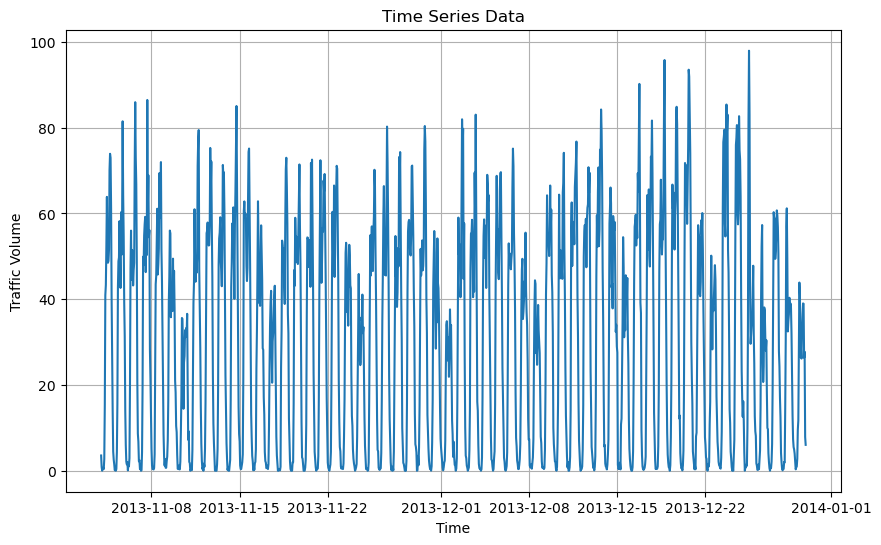

In [296]:
plt.figure(figsize=(10, 6))
plt.plot(df_reset['date_time'], df_reset[9164])
plt.xlabel('Time')
plt.ylabel('Traffic Volume')
plt.title('Time Series Data')
plt.grid(True)
plt.show()

In [303]:
### Univariable ###
### 데이터 셋 생성 ###
window_size = 72
forcast_size= 24
batch_size = 32
targets = 9164
date = 'date_time'

train_df_fe, test_df_fe, mean_, std_ = standardization(train_df, test_df, 'date_time', targets)
train_x, train_y, train_date = time_slide_df2(train_df_fe, window_size, forcast_size, date)
test_x, test_y, test_date = time_slide_df(test_df_fe, window_size, forcast_size, date, targets)


In [277]:

train_ds = Data(train_x[:1000], train_y[:1000])
valid_ds = Data(train_x[1000:], train_y[1000:])
test_ds = Data(test_x, test_y)

train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle=True,)

valid_dl = DataLoader(valid_ds, batch_size = train_x[1000:].shape[0], shuffle=False)
test_dl  = DataLoader(test_ds,  batch_size = test_x.shape[0], shuffle=False)

In [284]:
train_ds

In [280]:
### Llinear모델 학습 ###
train_loss_list = []
valid_loss_list = []
test_loss_list = []
epoch = 200
lr = 0.001
Linear_model = LTSF_Linear(
                            window_size=window_size,
                            forcast_size=forcast_size,
                            individual=False,
                            feature_size=1,
                            )
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(Linear_model.parameters(), lr=lr)
max_loss = 999999999

for epoch in tqdm(range(1, epoch+1)):
    loss_list = []
    Linear_model.train()
    for batch_idx, (data, target) in enumerate(train_dl):
        optimizer.zero_grad()
        output = Linear_model(data)
        loss = criterion(output, target.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_list.append(loss.item())    
    train_loss_list.append(np.mean(loss_list))

    Linear_model.eval()
    with torch.no_grad():
        for data, target in valid_dl:
            output = Linear_model(data)
            valid_loss = criterion(output, target.unsqueeze(-1))
            valid_loss_list.append(valid_loss)
        
        for data, target in test_dl:
            output = Linear_model(data)
            test_loss = criterion(output, target.unsqueeze(-1))
            test_loss_list.append(test_loss)

    if valid_loss < max_loss:
        torch.save(Linear_model, 'Linear_model.pth')
        max_loss = valid_loss
        print("valid_loss={:.3f}, test_los{:.3f}, Model Save".format(valid_loss, test_loss))
        linear_best_epoch = epoch
        linear_best_train_loss = np.mean(loss_list)
        linear_best_valid_loss = np.mean(valid_loss.item())
        linear_best_test_loss = np.mean(test_loss.item())

    print("epoch = {}, train_loss : {:.3f}, valid_loss : {:.3f}, test_loss : {:.3f}".format(epoch, np.mean(loss_list), valid_loss, test_loss))

  4%|█▏                         | 9/200 [00:00<00:04, 43.71it/s]

valid_loss=0.420, test_los0.355, Model Save
epoch = 1, train_loss : 0.566, valid_loss : 0.420, test_loss : 0.355
valid_loss=0.320, test_los0.291, Model Save
epoch = 2, train_loss : 0.273, valid_loss : 0.320, test_loss : 0.291
valid_loss=0.277, test_los0.262, Model Save
epoch = 3, train_loss : 0.221, valid_loss : 0.277, test_loss : 0.262
valid_loss=0.251, test_los0.249, Model Save
epoch = 4, train_loss : 0.192, valid_loss : 0.251, test_loss : 0.249
valid_loss=0.241, test_los0.244, Model Save
epoch = 5, train_loss : 0.174, valid_loss : 0.241, test_loss : 0.244
valid_loss=0.231, test_los0.238, Model Save
epoch = 6, train_loss : 0.165, valid_loss : 0.231, test_loss : 0.238
valid_loss=0.225, test_los0.234, Model Save
epoch = 7, train_loss : 0.157, valid_loss : 0.225, test_loss : 0.234
valid_loss=0.223, test_los0.235, Model Save
epoch = 8, train_loss : 0.155, valid_loss : 0.223, test_loss : 0.235
valid_loss=0.219, test_los0.233, Model Save
epoch = 9, train_loss : 0.151, valid_loss : 0.219, t

 10%|██▍                       | 19/200 [00:00<00:03, 45.82it/s]

valid_loss=0.211, test_los0.225, Model Save
epoch = 11, train_loss : 0.146, valid_loss : 0.211, test_loss : 0.225
valid_loss=0.208, test_los0.223, Model Save
epoch = 12, train_loss : 0.145, valid_loss : 0.208, test_loss : 0.223
epoch = 13, train_loss : 0.144, valid_loss : 0.208, test_loss : 0.220
valid_loss=0.207, test_los0.221, Model Save
epoch = 14, train_loss : 0.143, valid_loss : 0.207, test_loss : 0.221
valid_loss=0.204, test_los0.216, Model Save
epoch = 15, train_loss : 0.142, valid_loss : 0.204, test_loss : 0.216
epoch = 16, train_loss : 0.142, valid_loss : 0.204, test_loss : 0.215
valid_loss=0.202, test_los0.214, Model Save
epoch = 17, train_loss : 0.140, valid_loss : 0.202, test_loss : 0.214
valid_loss=0.200, test_los0.212, Model Save
epoch = 18, train_loss : 0.140, valid_loss : 0.200, test_loss : 0.212
epoch = 19, train_loss : 0.138, valid_loss : 0.201, test_loss : 0.213
valid_loss=0.198, test_los0.209, Model Save
epoch = 20, train_loss : 0.137, valid_loss : 0.198, test_loss 

 14%|███▊                      | 29/200 [00:00<00:03, 46.62it/s]

epoch = 21, train_loss : 0.138, valid_loss : 0.198, test_loss : 0.206
epoch = 22, train_loss : 0.137, valid_loss : 0.199, test_loss : 0.207
valid_loss=0.193, test_los0.199, Model Save
epoch = 23, train_loss : 0.138, valid_loss : 0.193, test_loss : 0.199
epoch = 24, train_loss : 0.135, valid_loss : 0.198, test_loss : 0.205
epoch = 25, train_loss : 0.135, valid_loss : 0.193, test_loss : 0.200
valid_loss=0.189, test_los0.195, Model Save
epoch = 26, train_loss : 0.135, valid_loss : 0.189, test_loss : 0.195
epoch = 27, train_loss : 0.133, valid_loss : 0.190, test_loss : 0.196
epoch = 28, train_loss : 0.134, valid_loss : 0.192, test_loss : 0.196
epoch = 29, train_loss : 0.133, valid_loss : 0.195, test_loss : 0.200
epoch = 30, train_loss : 0.133, valid_loss : 0.190, test_loss : 0.191


 20%|█████                     | 39/200 [00:00<00:03, 46.90it/s]

valid_loss=0.187, test_los0.191, Model Save
epoch = 31, train_loss : 0.133, valid_loss : 0.187, test_loss : 0.191
epoch = 32, train_loss : 0.131, valid_loss : 0.187, test_loss : 0.191
valid_loss=0.186, test_los0.190, Model Save
epoch = 33, train_loss : 0.132, valid_loss : 0.186, test_loss : 0.190
epoch = 34, train_loss : 0.132, valid_loss : 0.187, test_loss : 0.188
epoch = 35, train_loss : 0.132, valid_loss : 0.192, test_loss : 0.195
epoch = 36, train_loss : 0.131, valid_loss : 0.187, test_loss : 0.187
valid_loss=0.186, test_los0.185, Model Save
epoch = 37, train_loss : 0.131, valid_loss : 0.186, test_loss : 0.185
epoch = 38, train_loss : 0.132, valid_loss : 0.188, test_loss : 0.190
valid_loss=0.185, test_los0.183, Model Save
epoch = 39, train_loss : 0.129, valid_loss : 0.185, test_loss : 0.183
epoch = 40, train_loss : 0.130, valid_loss : 0.188, test_loss : 0.185


 24%|██████▎                   | 49/200 [00:01<00:03, 47.01it/s]

epoch = 41, train_loss : 0.131, valid_loss : 0.188, test_loss : 0.189
epoch = 42, train_loss : 0.129, valid_loss : 0.185, test_loss : 0.186
epoch = 43, train_loss : 0.129, valid_loss : 0.187, test_loss : 0.188
epoch = 44, train_loss : 0.129, valid_loss : 0.188, test_loss : 0.187
epoch = 45, train_loss : 0.129, valid_loss : 0.186, test_loss : 0.188
valid_loss=0.185, test_los0.181, Model Save
epoch = 46, train_loss : 0.130, valid_loss : 0.185, test_loss : 0.181
valid_loss=0.184, test_los0.182, Model Save
epoch = 47, train_loss : 0.129, valid_loss : 0.184, test_loss : 0.182
valid_loss=0.181, test_los0.177, Model Save
epoch = 48, train_loss : 0.130, valid_loss : 0.181, test_loss : 0.177
epoch = 49, train_loss : 0.128, valid_loss : 0.184, test_loss : 0.181
epoch = 50, train_loss : 0.128, valid_loss : 0.185, test_loss : 0.183


 30%|███████▋                  | 59/200 [00:01<00:02, 47.35it/s]

epoch = 51, train_loss : 0.127, valid_loss : 0.181, test_loss : 0.177
epoch = 52, train_loss : 0.127, valid_loss : 0.183, test_loss : 0.182
epoch = 53, train_loss : 0.128, valid_loss : 0.182, test_loss : 0.181
epoch = 54, train_loss : 0.128, valid_loss : 0.184, test_loss : 0.183
epoch = 55, train_loss : 0.129, valid_loss : 0.182, test_loss : 0.181
epoch = 56, train_loss : 0.127, valid_loss : 0.181, test_loss : 0.178
epoch = 57, train_loss : 0.127, valid_loss : 0.184, test_loss : 0.182
epoch = 58, train_loss : 0.128, valid_loss : 0.182, test_loss : 0.176
epoch = 59, train_loss : 0.127, valid_loss : 0.187, test_loss : 0.184
valid_loss=0.181, test_los0.176, Model Save
epoch = 60, train_loss : 0.126, valid_loss : 0.181, test_loss : 0.176


 34%|████████▉                 | 69/200 [00:01<00:02, 47.47it/s]

epoch = 61, train_loss : 0.128, valid_loss : 0.187, test_loss : 0.186
epoch = 62, train_loss : 0.127, valid_loss : 0.188, test_loss : 0.187
epoch = 63, train_loss : 0.127, valid_loss : 0.181, test_loss : 0.179
epoch = 64, train_loss : 0.126, valid_loss : 0.182, test_loss : 0.176
epoch = 65, train_loss : 0.126, valid_loss : 0.182, test_loss : 0.177
epoch = 66, train_loss : 0.126, valid_loss : 0.184, test_loss : 0.180
epoch = 67, train_loss : 0.125, valid_loss : 0.183, test_loss : 0.179
epoch = 68, train_loss : 0.126, valid_loss : 0.184, test_loss : 0.181
epoch = 69, train_loss : 0.127, valid_loss : 0.181, test_loss : 0.177
epoch = 70, train_loss : 0.127, valid_loss : 0.183, test_loss : 0.181


 40%|██████████▎               | 79/200 [00:01<00:02, 47.51it/s]

epoch = 71, train_loss : 0.127, valid_loss : 0.183, test_loss : 0.179
epoch = 72, train_loss : 0.126, valid_loss : 0.181, test_loss : 0.176
epoch = 73, train_loss : 0.126, valid_loss : 0.183, test_loss : 0.179
epoch = 74, train_loss : 0.126, valid_loss : 0.184, test_loss : 0.178
epoch = 75, train_loss : 0.126, valid_loss : 0.183, test_loss : 0.178
epoch = 76, train_loss : 0.125, valid_loss : 0.183, test_loss : 0.179
valid_loss=0.177, test_los0.168, Model Save
epoch = 77, train_loss : 0.126, valid_loss : 0.177, test_loss : 0.168
epoch = 78, train_loss : 0.126, valid_loss : 0.177, test_loss : 0.171
valid_loss=0.176, test_los0.170, Model Save
epoch = 79, train_loss : 0.128, valid_loss : 0.176, test_loss : 0.170
epoch = 80, train_loss : 0.126, valid_loss : 0.181, test_loss : 0.175


 44%|███████████▌              | 89/200 [00:01<00:02, 47.64it/s]

epoch = 81, train_loss : 0.127, valid_loss : 0.180, test_loss : 0.171
epoch = 82, train_loss : 0.126, valid_loss : 0.179, test_loss : 0.171
epoch = 83, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.172
epoch = 84, train_loss : 0.125, valid_loss : 0.180, test_loss : 0.174
epoch = 85, train_loss : 0.126, valid_loss : 0.178, test_loss : 0.172
epoch = 86, train_loss : 0.126, valid_loss : 0.180, test_loss : 0.173
epoch = 87, train_loss : 0.127, valid_loss : 0.182, test_loss : 0.175
epoch = 88, train_loss : 0.125, valid_loss : 0.181, test_loss : 0.170
epoch = 89, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.173
epoch = 90, train_loss : 0.126, valid_loss : 0.179, test_loss : 0.173


 50%|████████████▊             | 99/200 [00:02<00:02, 47.62it/s]

epoch = 91, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.175
epoch = 92, train_loss : 0.125, valid_loss : 0.184, test_loss : 0.176
epoch = 93, train_loss : 0.126, valid_loss : 0.186, test_loss : 0.181
epoch = 94, train_loss : 0.125, valid_loss : 0.180, test_loss : 0.172
epoch = 95, train_loss : 0.126, valid_loss : 0.180, test_loss : 0.175
epoch = 96, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.170
epoch = 97, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.173
epoch = 98, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.174
epoch = 99, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.175
epoch = 100, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.171


 55%|█████████████▋           | 109/200 [00:02<00:01, 47.56it/s]

valid_loss=0.176, test_los0.172, Model Save
epoch = 101, train_loss : 0.126, valid_loss : 0.176, test_loss : 0.172
epoch = 102, train_loss : 0.124, valid_loss : 0.180, test_loss : 0.176
epoch = 103, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.173
epoch = 104, train_loss : 0.125, valid_loss : 0.180, test_loss : 0.174
epoch = 105, train_loss : 0.126, valid_loss : 0.177, test_loss : 0.170
epoch = 106, train_loss : 0.126, valid_loss : 0.179, test_loss : 0.173
epoch = 107, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.175
epoch = 108, train_loss : 0.126, valid_loss : 0.179, test_loss : 0.171
epoch = 109, train_loss : 0.125, valid_loss : 0.184, test_loss : 0.176
epoch = 110, train_loss : 0.124, valid_loss : 0.178, test_loss : 0.170


 60%|██████████████▉          | 119/200 [00:02<00:01, 47.63it/s]

epoch = 111, train_loss : 0.126, valid_loss : 0.176, test_loss : 0.172
epoch = 112, train_loss : 0.125, valid_loss : 0.177, test_loss : 0.170
epoch = 113, train_loss : 0.124, valid_loss : 0.181, test_loss : 0.175
epoch = 114, train_loss : 0.125, valid_loss : 0.180, test_loss : 0.175
epoch = 115, train_loss : 0.124, valid_loss : 0.180, test_loss : 0.176
epoch = 116, train_loss : 0.125, valid_loss : 0.176, test_loss : 0.172
epoch = 117, train_loss : 0.125, valid_loss : 0.180, test_loss : 0.173
epoch = 118, train_loss : 0.124, valid_loss : 0.178, test_loss : 0.172
epoch = 119, train_loss : 0.125, valid_loss : 0.177, test_loss : 0.171
epoch = 120, train_loss : 0.125, valid_loss : 0.177, test_loss : 0.172


 64%|████████████████▏        | 129/200 [00:02<00:01, 47.65it/s]

epoch = 121, train_loss : 0.126, valid_loss : 0.181, test_loss : 0.176
epoch = 122, train_loss : 0.126, valid_loss : 0.180, test_loss : 0.178
epoch = 123, train_loss : 0.125, valid_loss : 0.181, test_loss : 0.177
epoch = 124, train_loss : 0.124, valid_loss : 0.184, test_loss : 0.175
epoch = 125, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.175
epoch = 126, train_loss : 0.126, valid_loss : 0.176, test_loss : 0.169
epoch = 127, train_loss : 0.126, valid_loss : 0.177, test_loss : 0.170
epoch = 128, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.173
valid_loss=0.176, test_los0.169, Model Save
epoch = 129, train_loss : 0.125, valid_loss : 0.176, test_loss : 0.169
epoch = 130, train_loss : 0.125, valid_loss : 0.181, test_loss : 0.175


 70%|█████████████████▍       | 139/200 [00:02<00:01, 47.50it/s]

epoch = 131, train_loss : 0.126, valid_loss : 0.179, test_loss : 0.177
epoch = 132, train_loss : 0.124, valid_loss : 0.178, test_loss : 0.174
epoch = 133, train_loss : 0.124, valid_loss : 0.184, test_loss : 0.176
epoch = 134, train_loss : 0.125, valid_loss : 0.177, test_loss : 0.173
epoch = 135, train_loss : 0.124, valid_loss : 0.181, test_loss : 0.178
epoch = 136, train_loss : 0.126, valid_loss : 0.180, test_loss : 0.175
epoch = 137, train_loss : 0.126, valid_loss : 0.179, test_loss : 0.174
valid_loss=0.175, test_los0.169, Model Save
epoch = 138, train_loss : 0.125, valid_loss : 0.175, test_loss : 0.169
valid_loss=0.175, test_los0.168, Model Save
epoch = 139, train_loss : 0.125, valid_loss : 0.175, test_loss : 0.168
epoch = 140, train_loss : 0.125, valid_loss : 0.177, test_loss : 0.170


 74%|██████████████████▋      | 149/200 [00:03<00:01, 47.42it/s]

epoch = 141, train_loss : 0.124, valid_loss : 0.177, test_loss : 0.170
epoch = 142, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.169
epoch = 143, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.173
epoch = 144, train_loss : 0.123, valid_loss : 0.181, test_loss : 0.176
epoch = 145, train_loss : 0.125, valid_loss : 0.181, test_loss : 0.177
epoch = 146, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.171
epoch = 147, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.172
epoch = 148, train_loss : 0.124, valid_loss : 0.181, test_loss : 0.175
epoch = 149, train_loss : 0.126, valid_loss : 0.177, test_loss : 0.175
epoch = 150, train_loss : 0.124, valid_loss : 0.180, test_loss : 0.178


 80%|███████████████████▉     | 159/200 [00:03<00:00, 47.51it/s]

epoch = 151, train_loss : 0.125, valid_loss : 0.180, test_loss : 0.173
epoch = 152, train_loss : 0.125, valid_loss : 0.177, test_loss : 0.174
epoch = 153, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.175
epoch = 154, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.176
epoch = 155, train_loss : 0.125, valid_loss : 0.180, test_loss : 0.173
epoch = 156, train_loss : 0.124, valid_loss : 0.177, test_loss : 0.171
epoch = 157, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.176
epoch = 158, train_loss : 0.125, valid_loss : 0.181, test_loss : 0.179
epoch = 159, train_loss : 0.125, valid_loss : 0.182, test_loss : 0.176
epoch = 160, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.172


 84%|█████████████████████▏   | 169/200 [00:03<00:00, 47.66it/s]

epoch = 161, train_loss : 0.126, valid_loss : 0.179, test_loss : 0.172
epoch = 162, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.173
epoch = 163, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.171
epoch = 164, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.173
epoch = 165, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.172
epoch = 166, train_loss : 0.125, valid_loss : 0.185, test_loss : 0.179
epoch = 167, train_loss : 0.124, valid_loss : 0.177, test_loss : 0.170
epoch = 168, train_loss : 0.126, valid_loss : 0.177, test_loss : 0.173
epoch = 169, train_loss : 0.123, valid_loss : 0.182, test_loss : 0.176
epoch = 170, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.173


 90%|██████████████████████▍  | 179/200 [00:03<00:00, 47.76it/s]

epoch = 171, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.172
epoch = 172, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.169
epoch = 173, train_loss : 0.126, valid_loss : 0.178, test_loss : 0.173
epoch = 174, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.173
epoch = 175, train_loss : 0.125, valid_loss : 0.181, test_loss : 0.177
epoch = 176, train_loss : 0.126, valid_loss : 0.178, test_loss : 0.172
epoch = 177, train_loss : 0.125, valid_loss : 0.177, test_loss : 0.169
epoch = 178, train_loss : 0.126, valid_loss : 0.178, test_loss : 0.171
epoch = 179, train_loss : 0.126, valid_loss : 0.179, test_loss : 0.173
epoch = 180, train_loss : 0.125, valid_loss : 0.184, test_loss : 0.179


 94%|███████████████████████▋ | 189/200 [00:04<00:00, 47.78it/s]

epoch = 181, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.172
epoch = 182, train_loss : 0.126, valid_loss : 0.178, test_loss : 0.174
epoch = 183, train_loss : 0.124, valid_loss : 0.178, test_loss : 0.172
epoch = 184, train_loss : 0.125, valid_loss : 0.178, test_loss : 0.174
epoch = 185, train_loss : 0.124, valid_loss : 0.176, test_loss : 0.168
epoch = 186, train_loss : 0.125, valid_loss : 0.179, test_loss : 0.175
epoch = 187, train_loss : 0.125, valid_loss : 0.176, test_loss : 0.168
epoch = 188, train_loss : 0.124, valid_loss : 0.176, test_loss : 0.170
epoch = 189, train_loss : 0.125, valid_loss : 0.177, test_loss : 0.174
epoch = 190, train_loss : 0.124, valid_loss : 0.182, test_loss : 0.179


100%|█████████████████████████| 200/200 [00:04<00:00, 47.22it/s]

epoch = 191, train_loss : 0.124, valid_loss : 0.180, test_loss : 0.174
epoch = 192, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.171
epoch = 193, train_loss : 0.124, valid_loss : 0.181, test_loss : 0.177
epoch = 194, train_loss : 0.123, valid_loss : 0.182, test_loss : 0.174
epoch = 195, train_loss : 0.125, valid_loss : 0.180, test_loss : 0.176
epoch = 196, train_loss : 0.123, valid_loss : 0.178, test_loss : 0.174
epoch = 197, train_loss : 0.124, valid_loss : 0.179, test_loss : 0.174
epoch = 198, train_loss : 0.123, valid_loss : 0.181, test_loss : 0.177
epoch = 199, train_loss : 0.125, valid_loss : 0.180, test_loss : 0.174
epoch = 200, train_loss : 0.126, valid_loss : 0.182, test_loss : 0.176


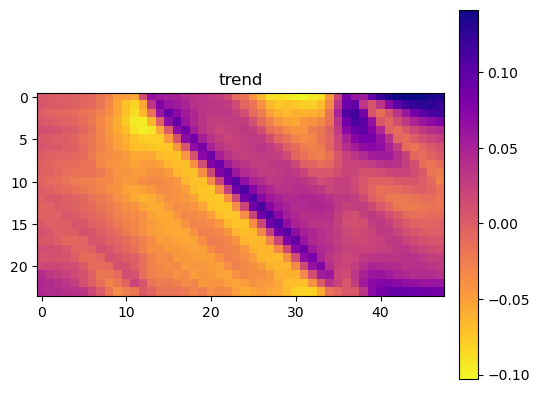

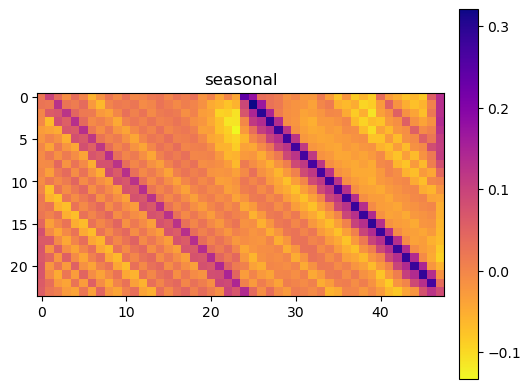

In [243]:
weights_list = {}
weights_list['trend'] = DLinear_model.Linear_Trend.weight.detach().numpy()
weights_list['seasonal'] = DLinear_model.Linear_Seasonal.weight.detach().numpy()

for name, w in weights_list.items():    
    fig, ax = plt.subplots()    
    plt.title(name)
    im = ax.imshow(w, cmap='plasma_r',)
    fig.colorbar(im, pad=0.03)
    plt.show()